In [1]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.wcs import WCS
from astropy.io import fits

from matplotlib.colors import LogNorm

from astropy.utils.data import download_file


#A100-NSA Catalog
myTab=Table.read('a100-nsa-for-adap.fits')

In [2]:
# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 20
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag = W3flag | NUVflag

In [3]:
# Size cut: r-band effective radii greater than two pixels (> 6.500" ) in the unWISE images
radmin = 5.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag = (rad_eff1>radmin) | (rad_eff2>radmin)

In [4]:
# Redshift cut: 0.002 < z < 0.025
zmin=0.002
zmax=0.025
redshift = myTab['ZDIST']
vhelio = myTab['Vhelio']
redshiftflag = (redshift>zmin) & (redshift<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = redshiftflag | vhelioflag 

In [5]:
# Apply cuts
NSFcut = SNRflag & sizeflag & zflag
cuttab=myTab[NSFcut]
cuttab.columns

<TableColumns names=('AGC','Name','OrigSrcName','HISrcName','RAdeg_HI','DECdeg_HI','RAdeg_OC','DECdeg_OC','RAdeg_Use','DECdeg_Use','Vhelio','sigV','W50','sigWtot','sigWstat','W20','HIflux','sigflux','SNR','RMS','Dist','sigdist','logMH','siglogMH','HIcode','objID_1','parentID','specObjID','ra_1','dec_1','modelMag_u','modelMag_g','modelMag_r','modelMag_i','modelMag_z','modelMagErr_u','modelMagErr_g','modelMagErr_r','modelMagErr_i','modelMagErr_z','cModelMag_u','cModelMag_g','cModelMag_r','cModelMag_i','cModelMag_z','cModelMagErr_u','cModelMagErr_g','cModelMagErr_r','cModelMagErr_i','cModelMagErr_z','petroMag_u','petroMag_g','petroMag_r','petroMag_i','petroMag_z','petroMagErr_u','petroMagErr_g','petroMagErr_r','petroMagErr_i','petroMagErr_z','petroRad_u','petroRad_g','petroRad_r','petroRad_i','petroRad_z','petroR50_g','petroR50_r','petroR50_i','petroR90_g','petroR90_r','petroR90_i','extinction_u','extinction_g','extinction_r','extinction_i','extinction_z','expAB_g','expAB_r','expAB_i','ex

In [6]:
#cuttab.info

In [7]:
#cuttab['logMstarTaylor']
#cuttab['ABSMAG'][:,5]
#cuttab['absMag_i']

13756


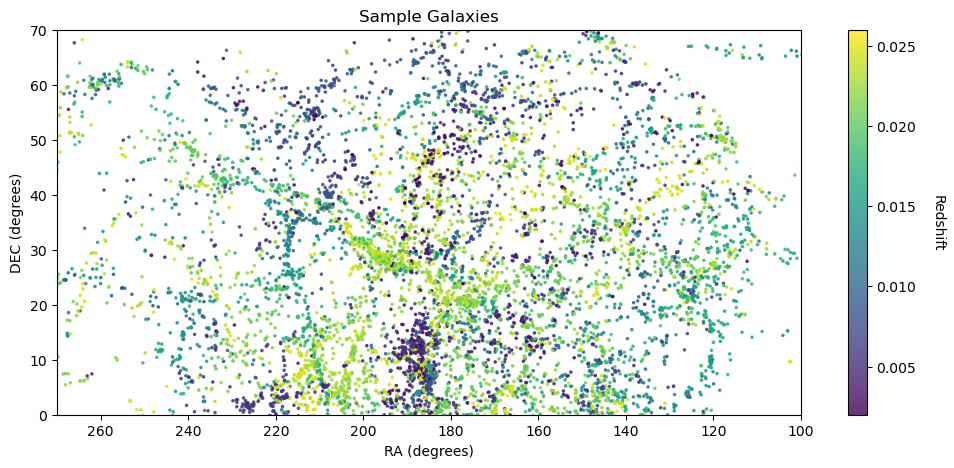

In [17]:
#Define positional and color data
ra = cuttab['RA']
dec = cuttab['DEC']
ccode = cuttab['ZDIST']

#Print number of points
print(len(ra))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='viridis',alpha=0.8,s=2.5)
plt.xlim(reversed(plt.xlim()))
plt.title('Sample Galaxies')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('Redshift',rotation=270,labelpad=20)
plt.clim(0.002,0.026)

C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_9780\2654246271.py:5: RuntimeWarning: divide by zero encountered in log10
  npx = np.array(np.log10(x1))


13756


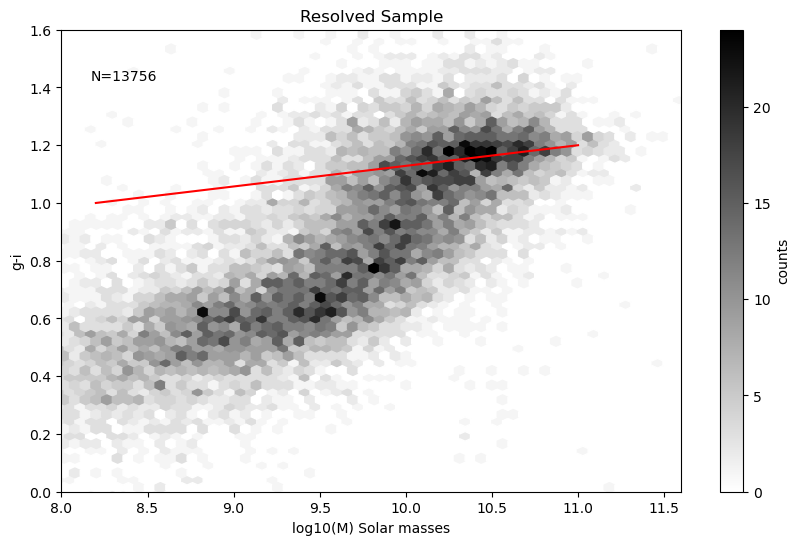

In [9]:
x1 = cuttab['MASS']
y1 = cuttab['ABSMAG'][:,3] - cuttab['ABSMAG'][:,5] #g-i magnitudes, FNUGRIZ- G[:,3] & I[:,5]

#Put x and y into numpy arrays
npx = np.array(np.log10(x1)) 
npy = np.array(y1)

#Prints sample size
print(len(npx))

#Figure size
fig,ax = plt.subplots(figsize=(10, 6))

#Hexbin parameters
hb = ax.hexbin(npx,npy,gridsize=[150,850],bins=25,cmap='gray_r')

#Plot hexbin mass vs color diagram
plt.title('Resolved Sample')
ax.set(xlim=(8,11.6),ylim=(0,1.6)) 
fig.colorbar(hb, label='counts') 
plt.xlabel('log10(M) Solar masses') 
plt.ylabel('g-i')

#Plot Red Sequence line
xx=np.array([8.2 ,11])
yy=np.array([ 1,  1.2])
plt.plot(xx,yy,color='r')
plt.text(0.1,0.9,'N=13756',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.show()

In [11]:
#New cut dataset
cut = SNRflag & zflag
tab=myTab[cut]

#Making arrays of 90% petrosian radii
p901 = np.array(tab['PETROTH90'])
p902 = np.array(cuttab['PETROTH90'])
p903 = np.array(tab['PETROTH90']) #np.array(tab['PETROTH90'])

#Setting lower bounds
p1 = (p901 != 0)
p2 = (p902 >= 1.7) #(p902 > 1.7)
p3 = (p903 >= 17.4) #(p901 > 17.4)

#Applying bounds to arrays
p90_01 = p901[p1]
p90_02 = p902[p2]
p90_03 = p903[p3]

In [12]:
#Half light radii
petroR501=tab['SERSIC_TH50']
petroR502=cuttab['SERSIC_TH50']

#Arrays of half light radii
p501 = np.array(tab['SERSIC_TH50'])
p502 = np.array(cuttab['SERSIC_TH50'])

#Lower bounds
c1 = (p501 > 0)
c2 = (p502 > 0)

#Applies lower bounds to arrays
p50_01 = p501[c1]
p50_02 = p502[c2]

Text(0.5, 0, 'r-band Half-Light Radius (arcsec)')

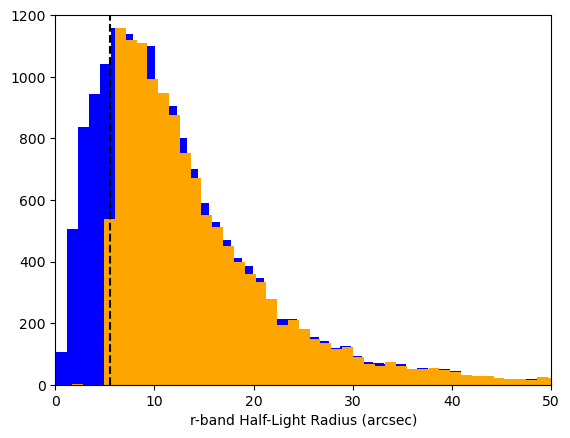

In [13]:
#Plot histogram of half light radii
plt.hist(p50_01,bins=145,color='blue')
plt.hist(p50_02,bins=145,color='orange')
plt.axvline(x = 5.5, color = 'black', linestyle='dashed')
plt.xlim(0,50)
plt.ylim(0,1200)
plt.xlabel('r-band Half-Light Radius (arcsec)')

Text(0.5, 0, 'r-band Diameter (arcsec)')

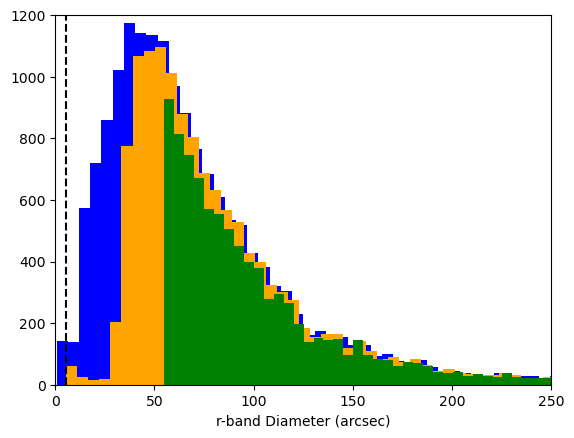

In [14]:
#Plot histogram of 3.16 times the 90% petrosian radii
plt.hist(3.16*p90_01,bins=85,color='blue') 
plt.hist(3.16*p90_02,bins=85,color='orange')
plt.hist(3.16*p90_03,bins=85,color='green') 
plt.axvline(x = 5.5, color = 'black', linestyle='dashed')
plt.ylim(0,1200)
plt.xlim(0,250)
plt.xlabel('r-band Diameter (arcsec)')

In [15]:
# SNR cut: GALEX NUV or WISE 12um SNR > 10
snrmin = 10
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag = W3flag | NUVflag

In [16]:
NSFcut1 = SNRflag & sizeflag & zflag
cuttab1=myTab[NSFcut1]

19192


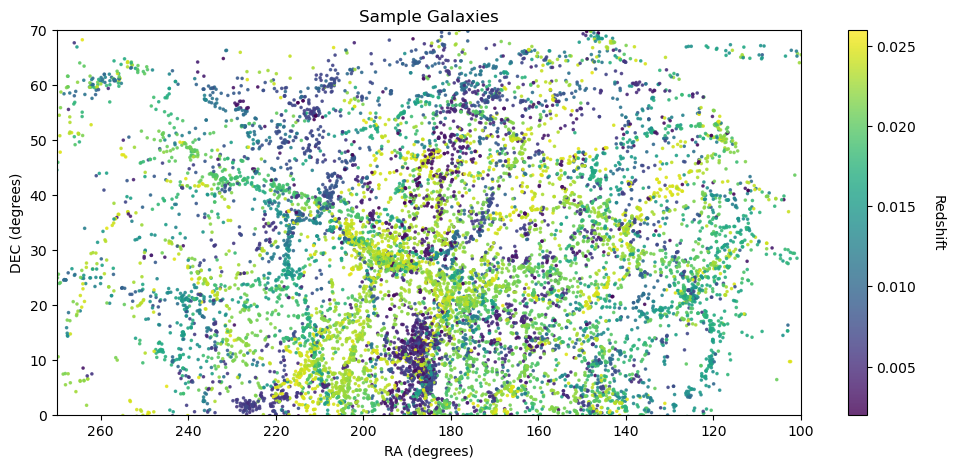

In [18]:
#Define positional and color data for SNR > 10
ra = cuttab1['RA']
dec = cuttab1['DEC']
ccode = cuttab1['ZDIST']

#Print number of points
print(len(ra))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='viridis',alpha=0.8,s=2.5)
plt.xlim(reversed(plt.xlim()))
plt.title('Sample Galaxies')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('Redshift',rotation=270,labelpad=20)
plt.clim(0.002,0.026)

C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_9780\2482626778.py:5: RuntimeWarning: divide by zero encountered in log10
  npx = np.array(np.log10(x1))


19192


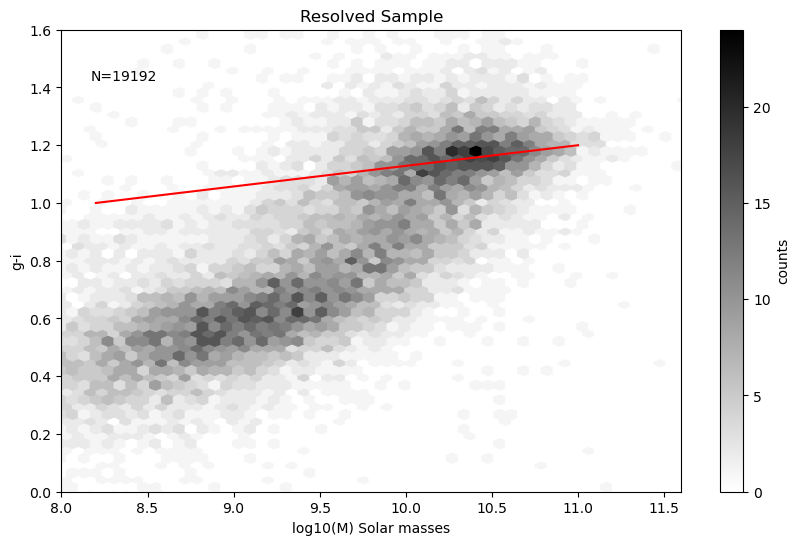

In [20]:
x1 = cuttab1['MASS']
y1 = cuttab1['ABSMAG'][:,3] - cuttab1['ABSMAG'][:,5] #g-i magnitudes, FNUGRIZ- G[:,3] & I[:,5]

#Put x and y into numpy arrays
npx = np.array(np.log10(x1)) 
npy = np.array(y1)

#Prints sample size
print(len(npx))

#Figure size
fig,ax = plt.subplots(figsize=(10, 6))

#Hexbin parameters
hb = ax.hexbin(npx,npy,gridsize=[150,850],bins=25,cmap='gray_r')

#Plot hexbin mass vs color diagram
plt.title('Resolved Sample')
ax.set(xlim=(8,11.6),ylim=(0,1.6)) 
fig.colorbar(hb, label='counts') 
plt.xlabel('log10(M) Solar masses') 
plt.ylabel('g-i')

#Plot Red Sequence line
xx=np.array([8.2 ,11])
yy=np.array([ 1,  1.2])
plt.plot(xx,yy,color='r')
plt.text(0.1,0.9,'N=19192',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.show()

In [21]:
# Size cut: r-band effective radii greater than two pixels (> 6.500" ) in the unWISE images
radmin = 6.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag = (rad_eff1>radmin) | (rad_eff2>radmin)

In [22]:
NSFcut2 = SNRflag & sizeflag & zflag
cuttab2=myTab[NSFcut2]

17215


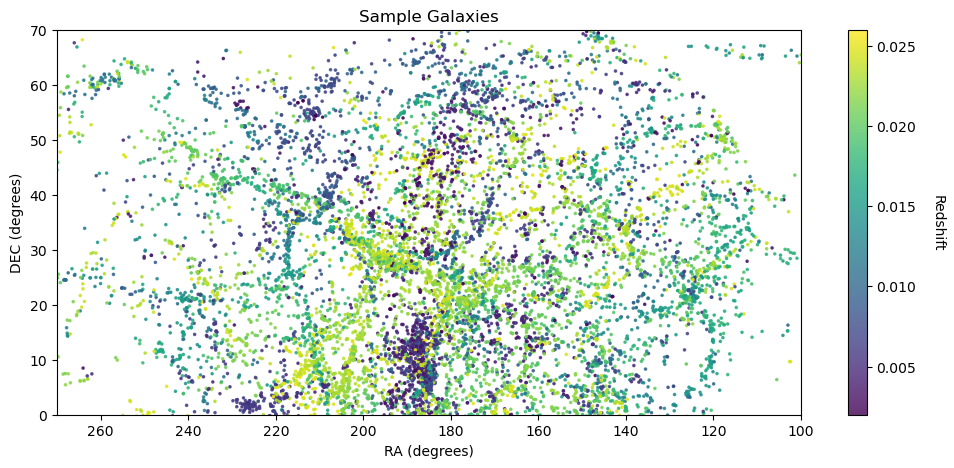

In [23]:
#Define positional and color data for size > 6.5
ra = cuttab2['RA']
dec = cuttab2['DEC']
ccode = cuttab2['ZDIST']

#Print number of points
print(len(ra))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='viridis',alpha=0.8,s=2.5)
plt.xlim(reversed(plt.xlim()))
plt.title('Sample Galaxies')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('Redshift',rotation=270,labelpad=20)
plt.clim(0.002,0.026)

C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_9780\1874915765.py:5: RuntimeWarning: divide by zero encountered in log10
  npx = np.array(np.log10(x1))


17215


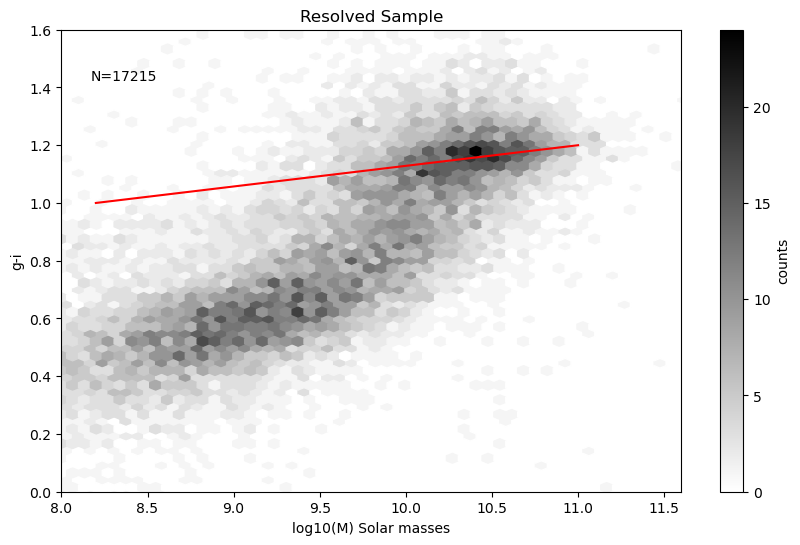

In [27]:
x1 = cuttab2['MASS']
y1 = cuttab2['ABSMAG'][:,3] - cuttab2['ABSMAG'][:,5] #g-i magnitudes, FNUGRIZ- G[:,3] & I[:,5]

#Put x and y into numpy arrays
npx = np.array(np.log10(x1)) 
npy = np.array(y1)

#Prints sample size
print(len(npx))

#Figure size
fig,ax = plt.subplots(figsize=(10, 6))

#Hexbin parameters
hb = ax.hexbin(npx,npy,gridsize=[150,850],bins=25,cmap='gray_r')

#Plot hexbin mass vs color diagram
plt.title('Resolved Sample')
ax.set(xlim=(8,11.6),ylim=(0,1.6)) 
fig.colorbar(hb, label='counts') 
plt.xlabel('log10(M) Solar masses') 
plt.ylabel('g-i')

#Plot Red Sequence line
xx=np.array([8.2 ,11])
yy=np.array([ 1,  1.2])
plt.plot(xx,yy,color='r')
plt.text(0.1,0.9,'N=17215',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.show()

In [24]:
# Size cut: r-band effective radii greater than two pixels (> 6.500" ) in the unWISE images
radmin = 6.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag = (rad_eff1>radmin) | (rad_eff2>radmin)

# SNR cut: GALEX NUV or WISE 12um SNR > 10
snrmin = 10
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag = W3flag | NUVflag

In [25]:
NSFcut3 = SNRflag & sizeflag & zflag
cuttab3 = myTab[NSFcut3]

17215


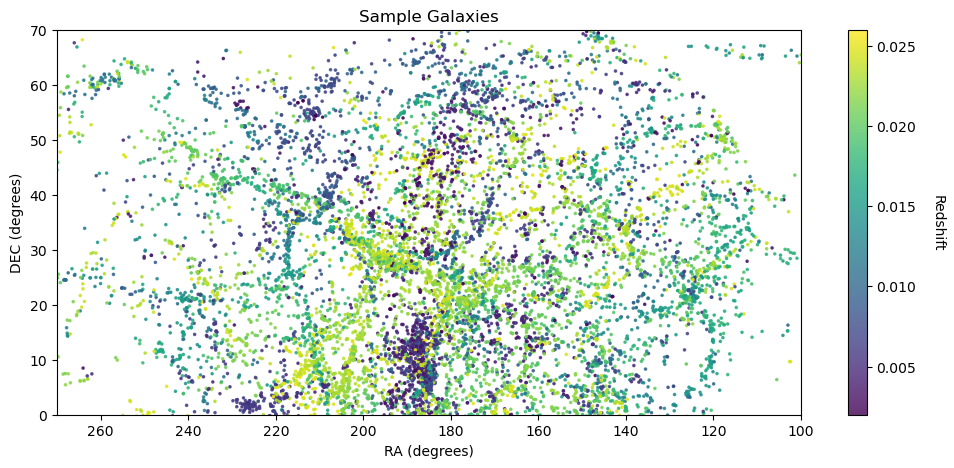

In [28]:
#Define positional and color data for size > 6.5 and SNR > 10
ra = cuttab3['RA']
dec = cuttab3['DEC']
ccode = cuttab3['ZDIST']

#Print number of points
print(len(ra))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='viridis',alpha=0.8,s=2.5)
plt.xlim(reversed(plt.xlim()))
plt.title('Sample Galaxies')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('Redshift',rotation=270,labelpad=20)
plt.clim(0.002,0.026)

C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_9780\2247151475.py:5: RuntimeWarning: divide by zero encountered in log10
  npx = np.array(np.log10(x1))


17215


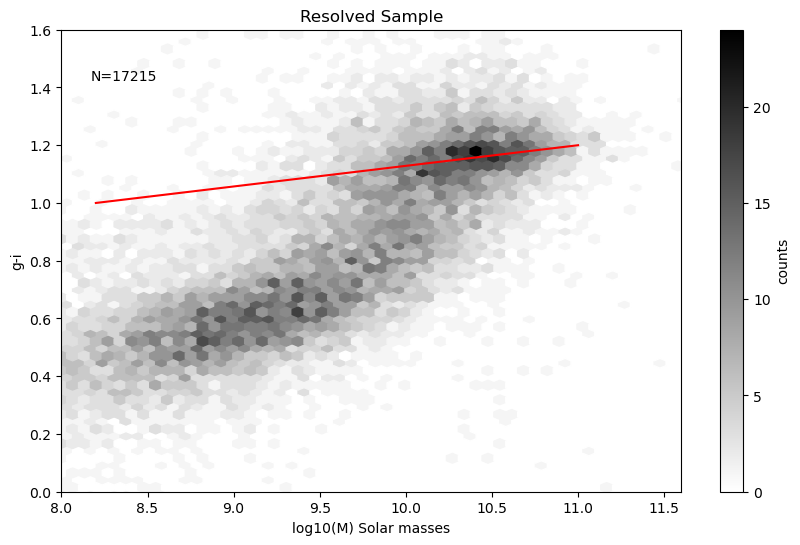

In [43]:
x1 = cuttab3['MASS']
y1 = cuttab3['ABSMAG'][:,3] - cuttab3['ABSMAG'][:,5] #g-i magnitudes, FNUGRIZ- G[:,3] & I[:,5]

#Put x and y into numpy arrays
npx = np.array(np.log10(x1)) 
npy = np.array(y1)

#Prints sample size
print(len(npx))

#Figure size
fig,ax = plt.subplots(figsize=(10, 6))

#Hexbin parameters
hb = ax.hexbin(npx,npy,gridsize=[150,850],bins=25,cmap='gray_r')

#Plot hexbin mass vs color diagram
plt.title('Resolved Sample')
ax.set(xlim=(8,11.6),ylim=(0,1.6)) 
fig.colorbar(hb, label='counts') 
plt.xlabel('log10(M) Solar masses') 
plt.ylabel('g-i')

#Plot Red Sequence line
xx=np.array([8.2 ,11])
yy=np.array([ 1,  1.2])
plt.plot(xx,yy,color='r')
plt.text(0.1,0.9,'N=17215',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.show()

Text(0.5, 0, 'Redshift')

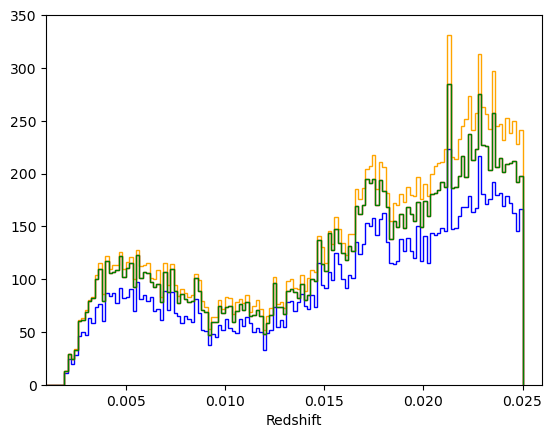

In [42]:
#Redshift histogram

a = cuttab['ZDIST']#5.5 and 20
b = cuttab1['ZDIST']#5.5 and 10
c = cuttab2['ZDIST']#6.5 and 20
d = cuttab3['ZDIST']#6.5 and 10

plt.hist(a,bins=145,histtype='step',color='blue',fill=False)
plt.hist(b,bins=145,histtype='step',color='orange',fill=False)
plt.hist(c,bins=145,histtype='step',color='red',fill=False)
plt.hist(d,bins=145,histtype='step',color='green',fill=False)
plt.xlim(0.001,0.026)
plt.ylim(0,350)
plt.xlabel('Redshift')